# Notebook to correlate vis 0.6 spectra of satellite images and measured sun intensity from weather stations

In [1]:
#### Functions to load data

from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
from collections import defaultdict
import rasterio
from datetime import datetime
from tensorflow import keras
from PIL import Image
from matplotlib.patches import Circle
from datetime import date

## Locations of weather stations


Tallinn-Harku
Laius: N 59°23´53´´
Pikkus: E 24°36´10´´
Decimal
Lat: 59.398055
Long: 24.602778


Haapsalu meteoroloogiajaam
Laius N 58°56´40´´
Pikkus E 23°33´18´´
Decimal
Lat: 58.944444
Long: 23.555

Narva
Laius: N 59°23´22´´
Pikkus: E 28°06´33´´
Decimal
Lat: 59.389444
Long: 28.109167

Pärnu
Laius: N 58°23´4,44´´
Pikkus: E 24°29´6,71´´
Decimal
Lat: 58.384556
Long: 24.485197

Roomassaare
Laius: N 58°13’05”
Pikkus: E 22°30’23”
Decimal
Lat: 58.218056 
Long: 22.506389 

Tartu-Tõravere meteoroloogiajaam
Laius: N 58°15´51´´
Pikkus: E 26°27´41´
Decimal
Lat: 58.264167
Long: 26.461389

Tiirikoja järvejaam
Laius: N 58°51´55´´
Pikkus: E 26°57´08´´
Decimal
Lat: 58.865278
Long: 26.952222

Vilsandi rannikujaam
Laius: N 58°22´58”
Pikkus: E 21°48´51”
Deciaml
Lat: 58.382778
Long: 21.814167

In [2]:
weather_station_coordinates = dict()
weather_station_coordinates["Tallinn-Harku"] = [59.398055, 24.602778]
weather_station_coordinates["Narva"] = [59.389444, 28.109167]
weather_station_coordinates["Pärnu"] = [58.384556, 24.485197]
weather_station_coordinates["Roomassaare"] = [58.218056, 22.506389]
weather_station_coordinates["Tartu-Tõravere"] = [58.264167, 26.461389]
weather_station_coordinates["Tiirikoja"] = [58.865278, 26.952222]
weather_station_coordinates["Vilsandi"] = [58.382778, 21.814167]

## Load satellite images

In [3]:


"""
Function for loading the satellite images
Arguments:
 selectedDataset - can be "2019-07" - e.g. specific month
                          "" - all months
 pictureTypes - list defining what sort of constellations are loaded
                "dnc" - 
                "dnm" - 24-hour Microphysics RGB

 pictureSize - Size to resize images to after they are read from disk. Defaults to (256, 256).
Returns:
  2 dictionaries
  dates - dates corresponding to pictures
  pictures - satellite pictures
"""


def loadSatelliteImages(selectedDatasets=["2019-07"], pictureTypes=["dnc", "dnm"], pictureSize=(256, 256)):
    pictures = defaultdict(lambda: defaultdict(list))
    dates = defaultdict(lambda: defaultdict(list))

    for selectedDataset in selectedDatasets:
        for pictureType in pictureTypes:
            satellitePictureNames = os.listdir(os.path.join(".", "data", selectedDataset, pictureType))

            for satellitePictureName in satellitePictureNames:
                # Load image
                imageDateStr = satellitePictureName.replace("dnc-", "").replace("dnm-", "").replace(".png", "")
                #Parse date to datetime 2019-07-01-05-45
                imageDate = datetime.strptime(imageDateStr, "%Y-%m-%d-%H-%M")
                img = image.load_img(os.path.join(".", "data", selectedDataset,
                                                  pictureType, satellitePictureName),
                                     target_size=pictureSize)
                # Convert to np array and add to list
                pictures[selectedDataset][pictureType].append(np.array(img))
                dates[selectedDataset][pictureType].append(imageDate)
            dates[selectedDataset][pictureType] = np.array(dates[selectedDataset][pictureType])
            pictures[selectedDataset][pictureType] = np.array(pictures[selectedDataset][pictureType])
            #Argsort
            sortedDates = np.argsort(dates[selectedDataset][pictureType])
            dates[selectedDataset][pictureType] = dates[selectedDataset][pictureType][sortedDates]
            pictures[selectedDataset][pictureType] = pictures[selectedDataset][pictureType][sortedDates]

    return pictures, dates


In [4]:
###### Some important variables
 
npixel = 128 # Define the pixel size of images
pictureType = ["dnc", "dnm"]
dataSets = ["2019-07","2019-08"]#,"2019-09","2019-10"]

In [5]:
sat, labels = loadSatelliteImages(selectedDatasets=dataSets, pictureTypes=pictureType, pictureSize=(npixel, npixel))

## Relate points in satellite image to weather station coordinates

In [6]:
def findPixel(latsMatrix, lonsMatrix, coordLat, coordLon):
    #Iterate over lattitude and longitude matrix to find coord
    accuracyDif = 0.07
    for i in range(len(latsMatrix)):
        for j in range(len(lonsMatrix[i])):
            currentLat = latsMatrix[i][j]
            currentLon = lonsMatrix[i][j]
            if(np.abs(currentLat-coordLat)<accuracyDif):
                if(np.abs(currentLon-coordLon)<accuracyDif):
                    return (j, i)
    #Nothing was found return
    return (None, None)

In [7]:
def resizeLatsLonsMatrix(latsMatrix, lonsMatrix, targetSize):
    result = [latsMatrix, lonsMatrix]
    for i in range(len(result)):
        pil = Image.fromarray(result[i])
        resized = pil.resize((targetSize,targetSize))
        resizedArray = np.array(resized)
        result[i] = resizedArray
    return result

In [8]:
#The initial coordinate matrix is for images 650x650
lats650 = np.load("./OstlandA/OstlandA-lats.npy")
lons650 = np.load("./OstlandA/OstlandA-lons.npy")
#Convert them to size (npixel x npixel)
lats_npixel, lons_npixel = resizeLatsLonsMatrix(lats650, lons650, npixel)

In [9]:
#Find the pixels where the weather stations are located
weather_station_loc_pixels = dict()
for station in weather_station_coordinates.keys():
    weather_station_loc_pixels[station]=findPixel(lats_npixel, lons_npixel, 
                          weather_station_coordinates[station][0], 
                          weather_station_coordinates[station][1])


In [10]:
weather_station_loc_pixels

{'Tallinn-Harku': (65, 51),
 'Narva': (92, 42),
 'Pärnu': (68, 71),
 'Roomassaare': (53, 79),
 'Tartu-Tõravere': (85, 68),
 'Tiirikoja': (86, 55),
 'Vilsandi': (47, 77)}

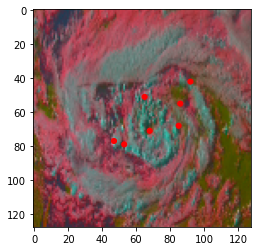

In [11]:
#Check that the locations are correct on one random image
fig, ax = plt.subplots(1)
ax.imshow(sat["2019-07"][pictureType[0]][450])
for station in weather_station_loc_pixels.keys():
    ax.add_patch(Circle((weather_station_loc_pixels[station][0],weather_station_loc_pixels[station][1]), radius=1.5, color="red"))

In [12]:
# Normalize the of satellite images to the 0-1 range.
for dataSet in sat.keys():
    for selectedPictureType in sat[dataSet].keys():
        print(dataSet)
        print(selectedPictureType)
        sat[dataSet][selectedPictureType] = sat[dataSet][selectedPictureType]/255

2019-07
dnc
2019-07
dnm
2019-08
dnc
2019-08
dnm


## Load solar intensity data from weather stations

In [13]:
# Some weather stations have changed locations over time, as the differences between their locations are rather small (less than 8 km)
# We at first do not make separation between them

def join_columns(c1, c2, nc, df, column_id): # Function for joining columns, where an area has two weather measuring points
    data = []
    cs = [c1, c2]
    for i, rows in df[cs].iterrows():
        if (pd.isna(rows[0]) == True) & (pd.isna(rows[1]) == False):
            data.append(round(rows[1], 2))
        elif (pd.isna(rows[0]) == False) & (pd.isna(rows[1]) == True):
            data.append(round(rows[0], 2))
        elif (pd.isna(rows[0]) == False) & (pd.isna(rows[1]) == False):
            data.append(round(rows.mean(), 2))
        elif (pd.isna(rows[0]) == True) & (pd.isna(rows[1]) == True):
            data.append(rows[0])

    df = df.drop(columns = [c1, c2])
    df.insert(column_id, nc, data)
    
    return df

In [14]:
#Create datetime object from year, month and day
def createDateTimeColumn(df):
    dateTimes = []
    for i in range(len(df)):
        row = df.iloc[i]
        dateTimes+=[datetime.combine(date(row.y, row.m, row.d), row.time)]
    df["dateTime"] = dateTimes

In [15]:
#Load initial data
hourly_sun_intensity = pd.read_excel('./data/2-10_21_524-2 Andmed.xlsx', sheet_name = 'tunni sum.kiirgus', header = 1)

In [16]:
#Update column names by shortening them and converting to English
newColumnNames = dict()
newColumnNames["Aasta"] = "y"
newColumnNames["Kuu"] = "m"
newColumnNames["Päaev"] = "d"
newColumnNames["Kell (UTC)"] = "time"

for columnName in hourly_sun_intensity.columns:
    if "kiirgus" in columnName:
        newColumnNames[columnName] = "solar_"+columnName.replace(" summaarne kiirgus, W/m²", "")
hourly_sun_intensity = hourly_sun_intensity.rename(columns=newColumnNames)


In [17]:
#Merge columns, which are due to weather station moving
hourly_sun_intensity = join_columns('solar_Narva', 'solar_Narva-Jõesuu', 'solar_Narva', hourly_sun_intensity, 4)
hourly_sun_intensity = join_columns('solar_Pärnu-Sauga', 'solar_Pärnu', 'solar_Pärnu', hourly_sun_intensity, 5)

In [18]:
#hourly_sun_intensity

In [19]:
#Drop rows where some value is missing
hourly_sun_intensity = hourly_sun_intensity.dropna()
#If value is -1 it corresponds to night, set it to 0
hourly_sun_intensity = hourly_sun_intensity.replace(-1, 0)

#Drop rows where sun is not shined for an hour
#for columnName in hourly_sun_intensity.columns:
#    print(columnName)
#    if "solar" in columnName:
#        hourly_sun_intensity = hourly_sun_intensity[hourly_sun_intensity[columnName]!=0]

In [20]:
#Create datetime object column for finding matching satellite images and rows of weather station data
createDateTimeColumn(hourly_sun_intensity)

In [21]:
#Shift the times -X minutes to facilitate predicting future solar intensity from existing
from datetime import timedelta
import copy
def shiftDateTime(df, numberOfHours):
    dateTimes = []
    for i in range(len(df)):
        row = df.iloc[i]
        dateTimes+=[datetime.combine(date(row.y, row.m, row.d), row.time)+timedelta(hours=numberOfHours)]
    df2 = copy.deepcopy(df)
    df2["y"] = [date.year for date in dateTimes]
    df2["m"] = [date.month for date in dateTimes]
    df2["d"] = [date.day for date in dateTimes]
    df2["time"] = [date.time() for date in dateTimes]
    
    return df2
    
    

In [22]:
##Shift solar intensity time -1 h to allow predicting future

hourly_sun_intensity_shifted = shiftDateTime(hourly_sun_intensity, -1)

### As satelite images are from 2019, we can drop other years

In [23]:
hourly_sun_intensity_shifted = hourly_sun_intensity_shifted[hourly_sun_intensity_shifted.y == 2019]

In [24]:
hourly_sun_intensity_shifted

,y,m,d,time,solar_Narva,solar_Pärnu,solar_Haapsalu,solar_Tallinn-Harku,solar_Roomassaare,solar_Tartu-Tõravere,solar_Tiirikoja,solar_Vilsandi,dateTime
78889,2019,1,1,00:00:00,0.0,0.0,0.0,0,0.0,0,0.0,0.0,2019-01-01 01:00:00
78890,2019,1,1,01:00:00,0.0,0.0,0.0,0,0.0,0,0.0,0.0,2019-01-01 02:00:00
78891,2019,1,1,02:00:00,0.0,0.0,0.0,0,0.0,0,0.0,0.0,2019-01-01 03:00:00
78892,2019,1,1,03:00:00,0.0,0.0,0.0,0,0.0,0,0.0,0.0,2019-01-01 04:00:00
78893,2019,1,1,04:00:00,0.0,0.0,0.0,0,0.0,0,0.0,0.0,2019-01-01 05:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
87644,2019,12,31,19:00:00,0.0,0.0,0.0,0,0.0,0,0.0,0.0,2019-12-31 20:00:00
87645,2019,12,31,20:00:00,0.0,0.0,0.0,0,0.0,0,0.0,0.0,2019-12-31 21:00:00
87646,2019,12,31,21:00:00,0.0,0.0,0.0,0,0.0,0,0.0,0.0,2019-12-31 22:00:00
87647,2019,12,31,22:00:00,0.0,0.0,0.0,0,0.0,0,0.0,0.0,2019-12-31 23:00:00


### Filter the data for matching

In [25]:
#Mask for selecting right rows of weather data and drop others

mask = np.asarray([hourly_sun_intensity_shifted["dateTime"].iloc[i] in labels[dataSets[0]][pictureType[0]] for i in range(len(hourly_sun_intensity_shifted["dateTime"]))])

for j in range(1,len(dataSets)):
    mask_aux = np.asarray([hourly_sun_intensity_shifted["dateTime"].iloc[i] in labels[dataSets[j]][pictureType[0]] for i in range(len(hourly_sun_intensity_shifted["dateTime"]))])
    mask = mask + mask_aux
hourly_sun_intensity_filtered = hourly_sun_intensity_shifted[mask]

# Create dataset

In [26]:
"""
Function for creating samples out of satellite data. Each row of X contains given number 
(imagesInSample) used to predict future weather. Rows of y are similar to y, although shifted
by one time interval

Arguments
dataDict - dictionary, which contains image data
X_imagetype - the type of images that are requested for X
Y_imagetype - the type of images that are requested for y
imageLabels - timestamps of images
weatherDataLabels - timestamps of weather data
imagesInSample - number of images in data row
"""
def createDataSetFromImages(dataDict, imagetype, imageLabels, weatherDataLabels, selectChannelX=None, imagesInSample=6, skipImages=1):
    X = []
    X_times = []
    for month in dataDict.keys():
        if selectChannelX is None:
            X_subset = dataDict[month][imagetype]
        else:
            X_subset = dataDict[month][imagetype][:,:,:,selectChannelX]
            # Add a channel dimension if using only one channel
            X_subset = np.expand_dims(X_subset, axis=-1)


        X_times_subset = imageLabels[month][imagetype]
        assert len(X_subset)==len(X_times_subset) # Lengths must match
        for i in range(0, len(X_subset)-imagesInSample-1):
            #Select only images, which last frame corresponds to time for which we
            #have solar intensity
            selected_X_last_frame_time = X_times_subset[i+1+imagesInSample]
            if(selected_X_last_frame_time in weatherDataLabels):
                #Select images so that y is shifted by one frame
                selected_X = X_subset[i:i+imagesInSample*skipImages:skipImages]
                X.append(selected_X)
                X_times.append(selected_X_last_frame_time)
    return np.array(X), np.array(X_times)

In [27]:
#Select only satellite images as prediction targets, where the last frame of RNN is in Weather data table
labelsAsTImestamps = [pd.Timestamp(value) for value in hourly_sun_intensity_filtered.dateTime.values]
X_dnc, X_times_dnc = createDataSetFromImages(sat, "dnc", labels, labelsAsTImestamps, imagesInSample=8)

In [28]:
X_dnm, X_times_dnm = createDataSetFromImages(sat, "dnm", labels, labelsAsTImestamps, imagesInSample=8)

In [29]:
X_dnm.shape

(1482, 8, 128, 128, 3)

### Link together points on satellite images and weather data

In [30]:
mask = [(X_time in labelsAsTImestamps) for X_time in X_times_dnc]
mask2 = [timeStamp in X_times_dnc for timeStamp in labelsAsTImestamps]

##
X_dnc_filtered = X_dnc[mask]
X_dnm_filtered = X_dnm[mask]
X_times_filtered = X_times_dnc[mask]


hourly_sun_intensity_filtered = hourly_sun_intensity_filtered[mask2]

In [31]:
X_times_filtered[130]

datetime.datetime(2019, 7, 6, 13, 0)

In [32]:
hourly_sun_intensity_filtered.dateTime.values[130]

numpy.datetime64('2019-07-06T13:00:00.000000000')

In [33]:
#Safety check for perfect match
for j in range(len(X_times_filtered)):
    if(np.datetime64(X_times_filtered[j])!=np.datetime64(hourly_sun_intensity_filtered["dateTime"].iloc[j])):
        print("Date mismatch")

In [34]:
X_filtered_images = dict()
X_filtered_images["dnc"] = X_dnc_filtered
X_filtered_images["dnm"] = X_dnm_filtered

### Transforming points on images and sunlight data to dataset

In [35]:
"""
Function for creating samples out of satellite data. Each row of X contains given number 
(imagesInSample) used to predict future weather. Rows of y are sun intensities at selected location,
although shifted
by one time interval

Arguments

"""
def createDataSetFromImagesToFeatures(satelliteData, intensityData, 
                                       weatherStationPixels):
    X = []
    y = []
    
    satelliteDataKeys = list(satelliteData.keys())
    numberOfSamples = len(satelliteData[satelliteDataKeys[0]])
    
    #For each sample
    for i in range(numberOfSamples):
        #For each weather station
        for weatherStation in weatherStationPixels.keys():
            selectedStation = weatherStationPixels[weatherStation]
            X_subset = []
            #For each frame in sample
            for j in range(len(satelliteData[satelliteDataKeys[0]][i])):
                #For all picture types
                X_sub_subset = []
                for picType in satelliteData.keys():
                    #Pick values from specific coordinates from image
                    X_sub_subset += list(satelliteData[picType][i][j][selectedStation[0], selectedStation[1]].flatten())
                X_subset+=X_sub_subset
            y+=[intensityData.iloc[i][("solar_"+weatherStation)]]
            X+=[X_subset]
        


            
    return np.array(X), np.array(y)

In [36]:
X_images_weather, y_intensity = createDataSetFromImagesToFeatures(X_filtered_images,
                                   hourly_sun_intensity_filtered, weather_station_loc_pixels)

In [37]:
X_times_filtered[150]

datetime.datetime(2019, 7, 7, 9, 0)

In [38]:
hourly_sun_intensity_filtered.dateTime.values[150]

numpy.datetime64('2019-07-07T09:00:00.000000000')

In [39]:
hourly_sun_intensity_filtered["solar_Tallinn-Harku"].values[75]

450

In [40]:
y_intensity[150]

0.0

In [41]:
X_images_weather.shape

(10374, 48)

In [42]:
y_intensity.shape

(10374,)

## Train and predict solar intensity using feature from satellite image and weather data

In [43]:
from tensorflow import keras
import tensorflow as tf

In [44]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [45]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_images_weather, y_intensity, test_size=0.2, random_state=111)

In [46]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [47]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [48]:
############### Random Forest ##############################

n_estimatorss = [100, 150]
max_depths=[5, 10,20, 30]
min_samples_splits=[4,6,8,16]
seeds = [1]
results_df = pd.DataFrame(columns=['model',"seed","n_estimators","max_depth","min_samples_split",'TrainError', 'ValError', 'deltaErrors'])
for seed in seeds:
    for n_estimator in n_estimatorss:
        for max_d in max_depths:
            for min_ss in min_samples_splits:
                rf = RandomForestRegressor(criterion="squared_error", n_estimators=n_estimator, max_depth=max_d, min_samples_split=min_ss, random_state=seed).fit(X_train_scaled, y_train)
                trainError = mean_squared_error(y_train, rf.predict(X_train_scaled), squared = False)
                valError = mean_squared_error(y_test, rf.predict(X_test_scaled), squared = False)
                results_df = results_df.append({'model': 'RF',"seed":seed,"n_estimators":n_estimator,"max_depth":max_d,"min_samples_split":min_ss,"TrainError":trainError, 'ValError':valError, 'deltaErrors':abs(trainError-valError)}, ignore_index=True)

In [49]:
results_df.sort_values("ValError")

,model,seed,n_estimators,max_depth,min_samples_split,TrainError,ValError,deltaErrors
29,RF,1,150,30,6,52.614859,124.323660,71.708801
30,RF,1,150,30,8,56.935694,124.330798,67.395103
25,RF,1,150,20,6,55.662233,124.365098,68.702866
24,RF,1,150,20,4,52.098407,124.388437,72.290030
28,RF,1,150,30,4,48.598269,124.443610,75.845340
26,RF,1,150,20,8,59.659660,124.455844,64.796184
9,RF,1,100,20,6,56.026672,124.561208,68.534536
14,RF,1,100,30,8,57.254553,124.565499,67.310946
13,RF,1,100,30,6,52.911165,124.602932,71.691767
31,RF,1,150,30,16,71.922628,124.605200,52.682572


In [50]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor


############### HistGradientBoostingRegressor ##############################

learning_rates = [0.3, 0.2, 0.1, 0.05, 0.01]
l2_regularizations=[0, 0.1, 0.2]
results_gb_df = pd.DataFrame(columns=['model',"lr","l2",'TrainError', 'ValError', 'deltaErrors'])
for learning_rate in learning_rates:
    for l2_regularization in l2_regularizations:
        gb = HistGradientBoostingRegressor(l2_regularization=l2_regularization, learning_rate=learning_rate).fit(X_train_scaled, y_train)
        trainError = mean_squared_error(y_train, gb.predict(X_train_scaled), squared = False)
        valError = mean_squared_error(y_test, gb.predict(X_test_scaled), squared = False)
        results_gb_df = results_gb_df.append({'model': 'GB', "lr":learning_rate , "l2":l2_regularization, "TrainError":trainError, 'ValError':valError, 'deltaErrors':abs(trainError-valError)}, ignore_index=True)

/home/main/anaconda3/envs/metsat/lib/python3.7/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:17: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  "Since version 1.0, "


In [51]:
results_gb_df.sort_values("ValError")

,model,lr,l2,TrainError,ValError,deltaErrors
10,GB,0.05,0.1,94.323444,122.914772,28.591328
11,GB,0.05,0.2,93.863733,123.883061,30.019329
6,GB,0.10,0,78.154098,124.199043,46.044946
9,GB,0.05,0,94.277935,124.281789,30.003854
8,GB,0.10,0.2,77.416966,124.685568,47.268603
7,GB,0.10,0.1,77.590499,124.710321,47.119822
3,GB,0.20,0,56.264742,124.868599,68.603857
5,GB,0.20,0.2,57.379154,125.628011,68.248857
4,GB,0.20,0.1,57.571659,126.395087,68.823428
2,GB,0.30,0.2,44.966515,128.623526,83.657011


In [ ]:

#https://www.tensorflow.org/tutorials/structured_data/time_series
#lstm_model = keras.models.Sequential([
#    # Shape [batch, time, features] => [batch, time, lstm_units]
#    keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, time, features]
#    keras.layers.Dense(units=1)
#])

#model = tf.keras.Sequential([
#    tf.keras.layers.Dense(units=64, activation='relu'),
#    tf.keras.layers.Dense(units=64, activation='relu'),
#    tf.keras.layers.Dense(units=1)
#])

model = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Dense(units=48, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
])


early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                patience=5,
                                                mode='min')

model.compile(loss=tf.losses.MeanSquaredError(),
            optimizer=tf.keras.optimizers.Adam(),
            metrics=[tf.metrics.MeanAbsoluteError()])

model.fit(X_images_weather, y_intensity, epochs=100, callbacks=[early_stopping])

2021-12-09 20:22:28.563564: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-09 20:22:28.564867: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2021-12-09 20:22:28.600693: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
325/325 [==============================] - 1s 1ms/step - loss: 48591.5391 - mean_absolute_error: 158.2154
Epoch 2/100
325/325 [==============================] - 0s 1ms/step - loss: 23836.0781 - mean_absolute_error: 105.8456
Epoch 3/100
325/325 [==============================] - 0s 1ms/step - loss: 22573.4336 - mean_absolute_error: 100.7222
Epoch 4/100
325/325 [==============================] - 1s 3ms/step - loss: 21303.8105 - mean_absolute_error: 96.2726
Epoch 5/100
325/325 [==============================] - 0s 1ms/step - loss: 20227.7246 - mean_absolute_error: 92.7077
Epoch 6/100
325/325 [==============================] - 0s 1ms/step - loss: 19540.1094 - mean_absolute_error: 90.4463
Epoch 7/100
325/325 [==============================] - 0s 1ms/step - loss: 19160.9043 - mean_absolute_error: 89.4127
Epoch 8/100
325/325 [==============================] - 1s 2ms/step - loss: 18802.5938 - mean_absolute_error: 87.9647
Epoch 9/100
325/325 [==============================] - 1s 2ms